# Image Preperation

To prepare our dataset for use we will need to do some cleaning and normalizing of the pictures. 
First, we will use the bounding box information we gathered earlier so that our photos will only
have dogs in them. Then we will resize the images so that they are uniform in addition to 
normalizing the colors. 

After we have created our high quality dog images we will do some image augmentation to help 
under represented breeds (n < 200) and breed categories (wild dogs and Foundation Stock Service).
We will do this using 


In [ ]:
import pandas as pd
import os 
import xml.etree.ElementTree as ET
from PIL import Image, ImageOps
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from kerastuner import HyperParameters
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv('resources/csv/dog_annotations_with_groups.csv')
df.head()

,filename,breed_name,folder,xmin,ymin,xmax,ymax,pose,truncated,difficult,group_x,group_y,group
0,n02085620_10074.jpg,chihuahua,n02085620-Chihuahua,25,10,276,498,Unspecified,0,0,Toy,Toy,Toy
1,n02085620_10131.jpg,chihuahua,n02085620-Chihuahua,49,9,393,493,Unspecified,0,0,Toy,Toy,Toy
2,n02085620_10621.jpg,chihuahua,n02085620-Chihuahua,142,43,335,250,Unspecified,0,0,Toy,Toy,Toy
3,n02085620_1073.jpg,chihuahua,n02085620-Chihuahua,0,27,312,498,Unspecified,0,0,Toy,Toy,Toy
4,n02085620_10976.jpg,chihuahua,n02085620-Chihuahua,90,104,242,452,Unspecified,0,0,Toy,Toy,Toy


In [16]:
error_log = []
cropped_folder = 'resources/stanford-dogs-dataset/cropped-images'
image_folder = 'resources/stanford-dogs-dataset/images'
breed_issues = {}

for _, row in df.iterrows():
    breed_name = row["breed_name"]
    folder_name = row["folder"].strip()  # Strip newlines & spaces
    filename = row["filename"].strip()  # Ensure filename is not empty

    # Check if filename is empty or incorrect
    if not filename or filename == "%s.jpg":
        # print(f"⚠️ Invalid filename for {breed_name} in {folder_name}")
        error_log.append(f"Invalid filename for {breed_name} in {folder_name}")
        continue  # Skip this entry

    img_path = os.path.join(image_folder, folder_name, filename)

    if not os.path.exists(img_path):
        # print(f"⚠️ Missing file: {img_path}")
        error_log.append(img_path)
        continue  # Skip missing images

    try: # Run of the mill image cropping routine
        # Open image
        img = Image.open(img_path)

        # Crop
        xmin, ymin, xmax, ymax = row["xmin"], row["ymin"], row["xmax"], row["ymax"]
        cropped_img = img.crop((xmin, ymin, xmax, ymax))

        # Ensure breed folder exists
        breed_cropped_path = os.path.join(cropped_folder, breed_name)
        os.makedirs(breed_cropped_path, exist_ok=True)

        # Save cropped image
        save_path = os.path.join(breed_cropped_path, filename)
        cropped_img.save(save_path)

    except Exception as e:
        error_log.append(f"{img_path} - {e}")

# Save error log
with open("missing_images_log.txt", "w") as f:
    for entry in error_log:
        f.write(f"{entry}\n")

print(f"✅ Cropping complete! {len(error_log)} issues logged.")

✅ Cropping complete! 1 issues logged.


In [17]:
expected_breeds = set(df["breed_name"].unique())
actual_breeds = set(os.listdir(cropped_folder))

# Check which breeds are missing from the folders
missing_folders = expected_breeds - actual_breeds
extra_folders = actual_breeds - expected_breeds

print("📌 Breeds in dataset but missing from image folders:", missing_folders)
print("📌 Extra breed folders that don't match dataset:", extra_folders)

📌 Breeds in dataset but missing from image folders: set()
📌 Extra breed folders that don't match dataset: set()


In [18]:
total_imgs = 0
for breed in os.listdir(cropped_folder):
    breed_path = os.path.join(cropped_folder, breed)
    num_images = len(os.listdir(breed_path))
    total_imgs += num_images

print(f"There are {total_imgs} cropped images")
print(f"There are {len(df['breed_name']) - total_imgs} missing images.")


There are 20579 cropped images
There are 1547 missing images.


Ok so we are missing 10% of our data for some reason. I am dealing with that later. 
## Image Normalization

In [19]:

def resize_with_padding(image, target_size=(256, 256)):
    """Resize an image while keeping aspect ratio and adding padding."""
    image = np.array(image)  # Ensure it's a NumPy array
    image = (image * 255).astype(np.uint8)  # Convert to uint8

    img = Image.fromarray(image)  # Convert to PIL Image
    img = ImageOps.fit(img, target_size, method=Image.Resampling.LANCZOS, centering=(0.5, 0.5))

    return np.array(img)  # Convert back to NumPy array


# Define a custom preprocessing function for ImageDataGenerator
def preprocess_image(image):
    """Resize with padding and normalize pixel values."""
    image = resize_with_padding(image)  # Resize and pad
    return image



In [20]:


# Define normalization and augmentation along with custom preprocessing
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values
    rotation_range=10,  # Rotate up to ±10 degrees
    width_shift_range=0.05,  # Shift image width by 5%
    height_shift_range=0.05,  # Shift image height by 5%
    shear_range=0.05,  # Shear transform
    zoom_range=0.1,  # Zoom in/out by up to 10%
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest',  # Fill in missing pixels after transformation
    preprocessing_function=preprocess_image  # Apply custom resize with padding
)

# Apply it in ImageDataGenerator
datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

train_generator = datagen.flow_from_directory(
    cropped_folder,  # Your dataset path
    target_size=(256, 256),  # The final target size
    batch_size=32
)


Found 20579 images belonging to 120 classes.


In [21]:
batch_images, batch_labels = next(train_generator)

# Print the batch shapes and pixel range
print(f"Image batch shape: {batch_images.shape}")  # Should be (batch_size, 256, 256, 3)
print(f"Label batch shape: {batch_labels.shape}")  # Should match the number of classes
print(f"Pixel range: min={batch_images.min()}, max={batch_images.max()}")  # Should be between 0 and 1



Image batch shape: (32, 256, 256, 3)
Label batch shape: (32, 120)
Pixel range: min=0.0, max=255.0


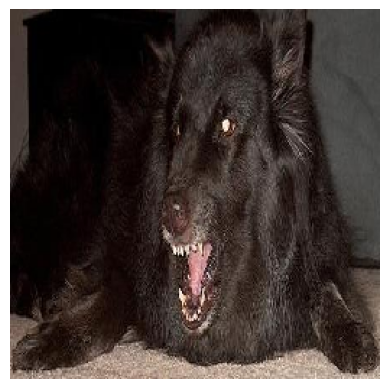

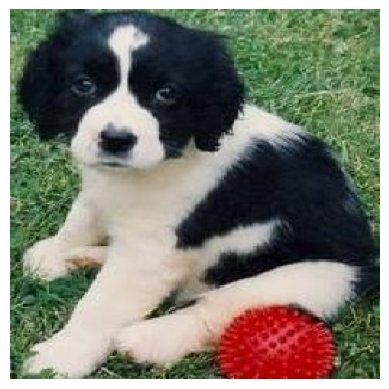

In [22]:
import matplotlib.pyplot as plt

# Displaying the first image in the batch
first_image = (batch_images[0] * 255).astype(np.uint8)  # Scale back to 0-255
plt.imshow(first_image)  # Display image with correct scaling
plt.axis('off')  # Hide axes
plt.show()

# Displaying the second image in the batch
second_image = (batch_images[1] * 255).astype(np.uint8)
plt.imshow(second_image)
plt.axis('off')
plt.show()


In [23]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    validation_split=0.2  # 20% validation
)

train_generator = datagen.flow_from_directory(
    cropped_folder,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    cropped_folder,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 16507 images belonging to 120 classes.
Found 4072 images belonging to 120 classes.


In [37]:
# Set variables for model code
IMG_SIZE = (256, 256)  # Image size
INPUT_SHAPE = (256, 256, 3)  # Image dimensions (RGB)
NUM_CLASSES = 120  # Number of dog breeds in your dataset

In [38]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# Load ResNet50 pre-trained on ImageNet without the top layers (so we can add our own)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False  # Freeze layers to prevent them from being trained

# Add your custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce dimensions
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout layer to avoid overfitting
x = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer for classification

# Create the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 25,808,888 (98.45 MB)

 Trainable params: 2,221,176 (8.47 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [40]:
# Unfreeze the top layers of the base model
for layer in base_model.layers[-10:]:  # Unfreeze the top 10 layers (you can adjust this)
    layer.trainable = True

# Recompile the model (necessary after changing the trainable layers)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Use a low learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_finetune = model.fit(train_generator,
                             validation_data=val_generator,
                             epochs=10,  # Fine-tune for more epochs
                             callbacks=[early_stopping])


Epoch 1/10
121/516 ━━━━━━━━━━━━━━━━━━━━ 12:15 2s/step - accuracy: 0.0126 - loss: 5.5103

KeyboardInterrupt: 

In [41]:

from tensorflow.keras.applications import VGG16

VG_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False  # Freeze layers to prevent them from being trained

# Add your custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce dimensions
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout layer to avoid overfitting
x = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer for classification

# Create the model
VG_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
VG_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
VG_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 25,808,888 (98.45 MB)

 Trainable params: 2,221,176 (8.47 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [42]:
from tensorflow.keras.applications import InceptionV3

Inc_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False  # Freeze layers to prevent them from being trained

# Add your custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling layer to reduce dimensions
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout layer to avoid overfitting
x = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer for classification

# Create the model
Inc_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
Inc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summarize the model
Inc_model.summary()


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 25,808,888 (98.45 MB)

 Trainable params: 2,221,176 (8.47 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# def create_model(hp):
#     model = Sequential()

#     # First Conv Layer with tunable filters & activation
#     model.add(Conv2D(
#         filters=hp.Int('conv1_filters', min_value=16, max_value=128, step=32),
#         kernel_size=(3,3), activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid']),
#         input_shape=INPUT_SHAPE
#     ))
#     model.add(MaxPooling2D(2, 2))  # We can use MaxPooling2D here initially

#     # Allow kerastuner to decide number of Conv layers
#     for i in range(hp.Int('num_conv_layers', 1, 4)):
#         model.add(Conv2D(
#             filters=hp.Int(f'conv_filters_{i}', min_value=16, max_value=128, step=32),
#             kernel_size=(3,3), activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])
#         ))
#         model.add(MaxPooling2D(2, 2))  # Add pooling here for additional reduction of spatial dimensions

#     model.add(GlobalAveragePooling2D())  # Apply GlobalAveragePooling2D later in the model

#     model.add(Flatten())

#     # Dense layers (fully connected) - tuning number of units and dropout rates
#     for i in range(hp.Int('num_dense_layers', 1, 3)):
#         model.add(Dense(
#             units=hp.Int(f'dense_units_{i}', min_value=64, max_value=512, step=64),
#             activation=hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])
#         ))
#         model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.2, max_value=0.5, step=0.1)))

#     # Output layer for multi-class classification
#     model.add(Dense(NUM_CLASSES, activation='softmax'))

#     # Compile the model
#     model.compile(
#         optimizer='adam',
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model


In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# # Define tuner with faster settings
# tuner = RandomSearch(
#     create_model,
#     objective='val_accuracy',
#     max_trials=10,  # ⬇️ Less models to test (faster tuning)
#     executions_per_trial=1,  # ⬇️ Train each model ONCE instead of twice!
#     directory='kerastuner_results',
#     project_name='dog_breed_classifier'
)

c:\Users\kbuma\anaconda3\envs\tflow\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
# Ensure your data is in the right format
print(f"Train Data: {train_generator}")
print(f"Validation Data: {val_generator}")

# To check how many batches per epoch:
print(f"Train Batches per epoch: {train_generator.samples // train_generator.batch_size}")
print(f"Validation Batches per epoch: {val_generator.samples // val_generator.batch_size}")


Train Data: <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x000001CFDA1D9750>
Validation Data: <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x000001CFD3B26800>
Train Batches per epoch: 515
Validation Batches per epoch: 127


In [ ]:
# # Run tuning
# tuner.search(train_generator, validation_data=val_generator, epochs=5)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
112               |112               |conv1_filters
tanh              |tanh              |activation
1                 |1                 |num_conv_layers
48                |48                |conv_filters_0
3                 |3                 |num_dense_layers
64                |64                |dense_units_0
0.4               |0.4               |dropout_0




c:\Users\kbuma\anaconda3\envs\tflow\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\kbuma\anaconda3\envs\tflow\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
516/516 ━━━━━━━━━━━━━━━━━━━━ 984s 2s/step - accuracy: 0.0081 - loss: 4.8582 - val_accuracy: 0.0106 - val_loss: 4.7953
Epoch 2/5
206/516 ━━━━━━━━━━━━━━━━━━━━ 8:37 2s/step - accuracy: 0.0090 - loss: 4.8087

KeyboardInterrupt: 

In [ ]:
# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

In [ ]:
# Print model summary
best_model.summary()  

In [ ]:
# Train the best model
history = best_model.fit(train_generator, validation_data=val_generator, epochs=20)

In [ ]:
model.save("dog_breed_classifier.h5")